# Domain Generalization for Pathology

This notebook initiates an exploratory data analysis (EDA) of the CAMELYON17 dataset, which is a critical first step in a domain generalization study.

In the context of this project, each of the five contributing medical centers is treated as a separate 'domain'. The core challenge of domain generalization is to train a robust model on data from these source domains so that it can accurately make predictions on data from a completely new, unseen hospital.

This initial analysis is designed to characterize and quantify the "domain shift" across the different centers by investigating:
*   The distribution of Whole Slide Images (WSIs) and patients across each domain (hospital).
*   The prevalence and distribution of metastasis labels within the training set.
*   Potential imbalances or biases in how data and labels are distributed among the domains, which is a key challenge for generalization.

The script executed below will generate and save visualizations of these distributions and produce a master CSV file. This file consolidates all the necessary information and explicitly annotates the source hospital as the 'domain' for each slide, setting the stage for training and evaluating domain generalization models.


In [ ]:
from source.analysis import summarize_dataset

summarize_dataset.generate_dataset_statistics()

# Download Data Files

 In this section we download the raw TIF files (Whole Slide Images) from the CAMELYON17 dataset. These images are high-resolution scans of lymph node tissue biopsies obtained from different medical centers. Each TIF file contains a complete microscopic scan of a lymph node section that will be used to detect metastatic tissue.

 **Note**: The full dataset is very large (hundreds of gigabytes). The script below is configured to download a small subset (data for the first 2 patients) for demonstration purposes. To download the entire dataset, you can remove the `max_patients` argument from the function call.

 These images form the core data that we'll analyze to study domain generalization across different hospitals' imaging systems and protocols.


In [1]:
from source.dataset import download_dataset

download_dataset.download_tif_files(max_patients=1)

Dataset directory: /home/dagopa/data/CAMELYON17/WSI
S3 Source: s3://camelyon-dataset/CAMELYON17/images/
Listing all available files from S3...
Limiting download to the first 1 patients.
Identified 5 slides for 1 patients.
Found 5 TIFF files to process.

Processing s3://camelyon-dataset/CAMELYON17/images/patient_000_node_0.tif...
File 'patient_000_node_0.tif' already exists and size matches. Skipping download.

Processing s3://camelyon-dataset/CAMELYON17/images/patient_000_node_1.tif...
File 'patient_000_node_1.tif' already exists and size matches. Skipping download.

Processing s3://camelyon-dataset/CAMELYON17/images/patient_000_node_2.tif...
File 'patient_000_node_2.tif' already exists and size matches. Skipping download.

Processing s3://camelyon-dataset/CAMELYON17/images/patient_000_node_3.tif...
File 'patient_000_node_3.tif' already exists and size matches. Skipping download.

Processing s3://camelyon-dataset/CAMELYON17/images/patient_000_node_4.tif...
File 'patient_000_node_4.tif'

# Visualize Example WSI Images

In this section, we visualize example Whole Slide Images (WSIs) from each medical center in the CAMELYON17 dataset. This visualization helps us understand the visual characteristics and potential differences between the different domains (hospitals) in our dataset.

The visualization will show thumbnail images organized by site, allowing us to observe any visual variations in tissue preparation, staining, imaging protocols, or other factors that might contribute to domain shift.


Starting simple CAMELYON17 WSI thumbnail visualization...
Searching for WSI files in: /home/dagopa/data/CAMELYON17/WSI
Found first WSI file: /home/dagopa/data/CAMELYON17/WSI/patient_000_node_1.tif
Creating thumbnail for: patient_000_node_1.tif


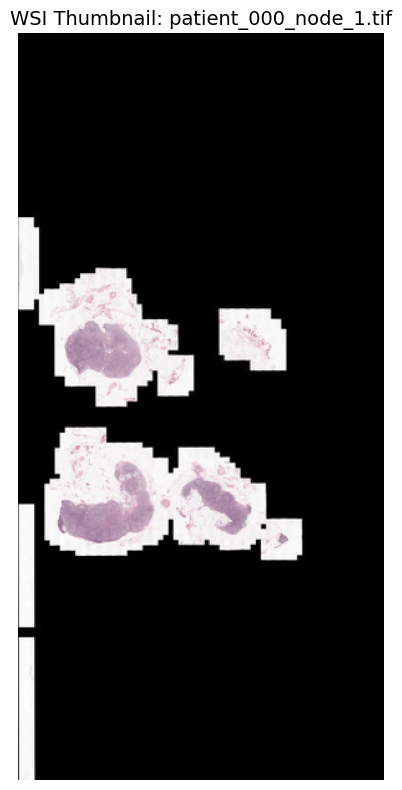

Visualization complete!


In [2]:
from source.visualization import visualize_example_wsi

visualize_example_wsi.visualize_wsi_thumbnail()

# Visual Analysis of WSI Thumbnails

The visualization above displays thumbnail images of lymph node tissue sections from different medical centers in the CAMELYON17 dataset. Each row represents a different hospital/site, and we can observe several important characteristics:

**Visual Observations:**
- **Staining Variations**: Different sites may show variations in H&E (Hematoxylin and Eosin) staining intensity and color balance, which can affect the pink and purple hues of the tissue
- **Tissue Preparation**: Variations in tissue sectioning thickness and preparation protocols may result in different tissue textures and clarity
- **Image Quality**: Different scanning equipment and protocols across hospitals may lead to variations in image resolution, brightness, and contrast
- **Tissue Types**: While all images show lymph node tissue, there may be variations in the specific anatomical regions captured and the amount of surrounding tissue included

These visual differences represent the core challenge of domain generalization - training a model that can perform well across all these visual variations while still accurately detecting metastatic tissue regardless of the source hospital's imaging characteristics.


# Tissue Segmentation

In this step, we perform tissue segmentation on the Whole Slide Images (WSIs). The goal is to separate the tissue regions (foreground) from the empty slide background. This is a crucial preprocessing step that allows subsequent analyses, such as patch extraction, to focus solely on relevant areas, saving a significant amount of computation time.

The segmentation process is as follows:

1. **Downsampling**: The WSI is read at a low resolution level for fast processing.
2. **Preprocessing**: The image is preprocessed by:
   - Converting to grayscale
   - Applying Gaussian blur to reduce noise
   - Using Otsu's thresholding method to create an initial binary mask
3. **Morphological Operations**: 
   - Opening operation to remove small noise
   - Closing operation to fill small holes
4. **Region Filtering**: Removing small disconnected regions below a size threshold
5. **Edge Refinement**: Using contour detection to identify and retain only significant tissue regions

The following script processes each WSI, generates a final tissue mask, and saves a visualization comparing the original thumbnail, the mask, and the thumbnail with the background removed.




Processing a subset of 2 slides.

--- Processing: patient_000_node_0.tif ---
Using the lowest available resolution level: 8 for efficient segmentation.
Visualization saved to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_0/patient_000_node_0_visualization.png
Displaying plot for the first slide...


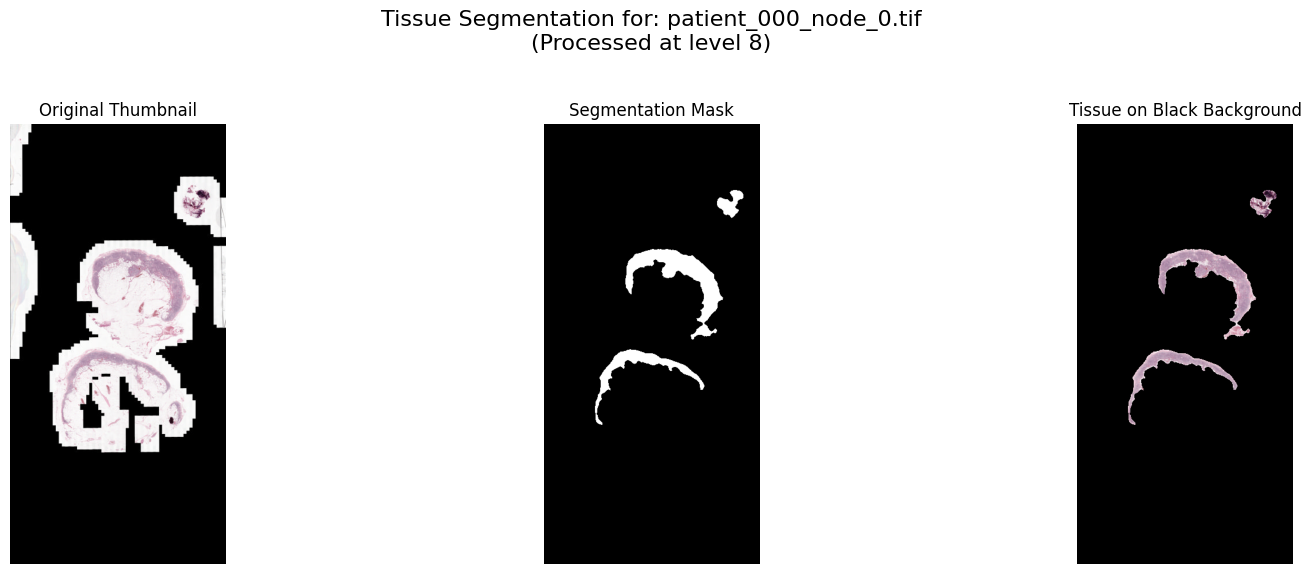

Low-resolution mask saved to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_0/patient_000_node_0_low_res_mask.png
Contours saved in GeoJSON format to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_0/patient_000_node_0_contours.geojson
Parameters saved to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_0/patient_000_node_0_params.json

--- Processing: patient_000_node_1.tif ---
Using the lowest available resolution level: 8 for efficient segmentation.
Visualization saved to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_1/patient_000_node_1_visualization.png
Low-resolution mask saved to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_1/patient_000_node_1_low_res_mask.png
Contours saved in GeoJSON format to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_1/patient_000_node_1_contours.geojson
Parameters saved

In [2]:
from source.preprocessing import segmentation

segmentation.process_all_slides(max_slides=2, save_visualization=True, show_first_slide=True)

# Patch Extraction Process (Tiling)

The tiling process breaks down large Whole Slide Images (WSIs) into smaller, manageable patches for analysis. Here's how it works:

1. **Input Processing**:
   - Takes segmented WSI images as input
   - Uses the tissue masks generated in the segmentation step

2. **Patch Extraction**:
   - Divides each WSI into 256x256 pixel patches
   - Only extracts patches that contain tissue (based on mask)
   - Skips patches that are mostly background

3. **Organization**:
   - Patches are organized by slide ID
   - Each patch is assigned coordinates indicating its location in original WSI
   - Patches that overlap with tumor regions are labeled accordingly

4. **Storage**:
   - Patches are saved as individual image files (JPG/PNG format)
   - Visualization of patch grid shown during processing
   - Maintains a mapping of patch locations and their labels in CSV format
   - Enables efficient data loading during model training

This process makes the large WSIs more manageable for deep learning analysis while preserving spatial relationships and tumor annotations.


Processing a subset of 5 slides.

--- Processing: patient_000_node_0 ---
  Processing WSI: patient_000_node_0.tif
  Calculating valid coordinates with a forced step size of 896px...
  Generating detailed grid visualization...
  Visualization saved to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_0/patient_000_node_0_tiling_grid_visualization.png
  Displaying plot for the first slide...


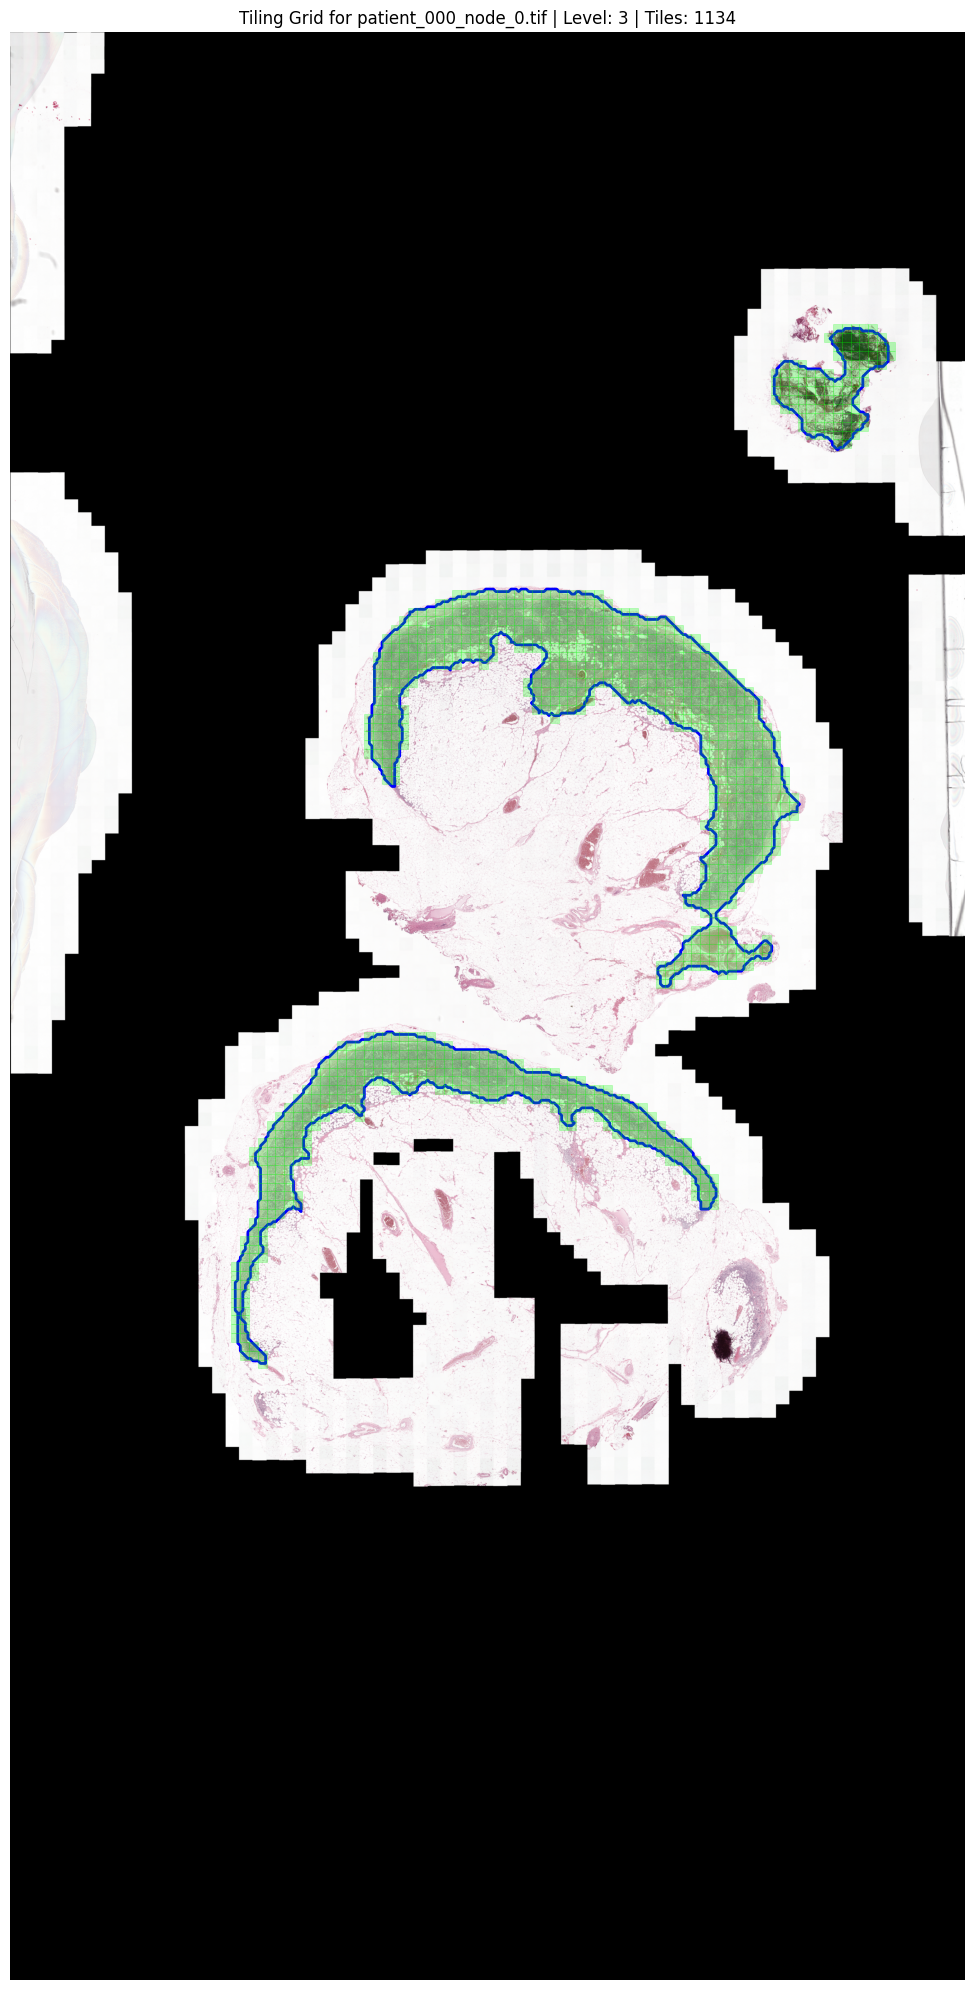

  Found 1134 valid coordinates. Saving to CSV...
  Coordinates saved to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_0/coordinates.csv

--- Processing: patient_000_node_1 ---
  Processing WSI: patient_000_node_1.tif
  Calculating valid coordinates with a forced step size of 896px...
  Found 862 valid coordinates. Saving to CSV...
  Coordinates saved to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_1/coordinates.csv

--- Processing: patient_000_node_2 ---
  Processing WSI: patient_000_node_2.tif
  Calculating valid coordinates with a forced step size of 896px...
  Found 957 valid coordinates. Saving to CSV...
  Coordinates saved to: /home/dagopa/projects/domain-pathology/outputs/segmentation/patient_000_node_2/coordinates.csv

--- Processing: patient_000_node_3 ---
  Processing WSI: patient_000_node_3.tif
  Calculating valid coordinates with a forced step size of 896px...
  Found 493 valid coordinates. Saving to CSV...
  C

In [3]:
from source.preprocessing import tiling

tiling.process_all_slides(max_slides=5, show_first_slide_tiling=True)

### Feature Extraction

This section outlines the two-stage feature extraction process applied to the Whole Slide Images (WSIs). The objective is to transform the images into numerical representations for use in machine learning models. The process utilizes two pre-trained models from the Mahmood Lab: **CONCH** for patch-level extraction and **TITAN** for slide-level aggregation.

---

#### **Stage 1: Patch-Level Feature Extraction with CONCH**

The first stage analyzes each WSI at a granular level. The process is as follows:

1.  **Data Loading**: A `PatchDataset` is used to load patches (small sections of the image) from each WSI, based on coordinates from the *tiling* step.
2.  **Processing with CONCH**: Each patch is passed through the **CONCH** model (`mahmoodlab/conch`), an image encoder, to extract features.
3.  **Storage**: The features from each patch, along with their coordinates, are saved in an HDF5 file (`features_conch.h5`). This file stores a detailed representation of the tissue on the slide.

---

#### **Stage 2: Slide-Level Feature Aggregation with TITAN**

The second stage aggregates the patch features to obtain a single representation for the entire slide.

1.  **Loading Patch Features**: The patch embeddings are read from the HDF5 file generated in the previous stage.
2.  **Aggregation with TITAN**: The **TITAN** model (`mahmoodlab/titan-256-128-l`), an attention-based model, is used to weight and aggregate the features of all patches into a single 768-dimensional feature vector.
3.  **Final Result**: The final feature vector for each slide is saved as a NumPy file (`feature_slide_titan.npy`), which can then be used for training classification models or for other analyses.

The following code block executes this complete pipeline, processing each WSI through both stages to generate the final slide-level embeddings.


In [3]:
from source.features import feature_extraction
feature_extraction.process_all_slides(max_slides=5)

--- Loading official Mahmood Lab models from Hugging Face ---
--- Using device: cpu ---
Models loaded successfully.

--- Processing: patient_000_node_0 ---
  Skipping patch extraction: features_conch.h5 already exists.
  Skipping slide aggregation: feature_slide_titan.npy already exists.

--- Processing: patient_000_node_1 ---
  Skipping patch extraction: features_conch.h5 already exists.
  Skipping slide aggregation: feature_slide_titan.npy already exists.

--- Processing: patient_000_node_2 ---
  Skipping patch extraction: features_conch.h5 already exists.
  Skipping slide aggregation: feature_slide_titan.npy already exists.

--- Processing: patient_000_node_3 ---
  Skipping patch extraction: features_conch.h5 already exists.
  Skipping slide aggregation: feature_slide_titan.npy already exists.

--- Processing: patient_000_node_4 ---
  Skipping patch extraction: features_conch.h5 already exists.
  Skipping slide aggregation: feature_slide_titan.npy already exists.

--- All slides hav